In [1]:
from sklearn.metrics import mutual_info_score
from collections import deque
from adjustText import adjust_text

import matplotlib.pyplot as plt
import pandas as pd
import koreanize_matplotlib
import seaborn as sns
import numpy as np
import scipy.stats as stats
import mysql.connector

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# 한글 폰트 사용을 위해서 세팅
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import font_manager, rc

font_path = "/usr/share/fonts/NanumFont/NanumGothic.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# import warnings
# warnings.filterwarnings("ignore")

import configparser

In [2]:
# DB 접속

config = configparser.ConfigParser()
config.read('../config.ini')
dev = config['dev']

remote = mysql.connector.connect(
    host = dev['host'],
    port = dev['port'],
    user = dev['user'],
    password = dev['password'],
    database = dev['database']
)

mycursor = remote.cursor(buffered=True)

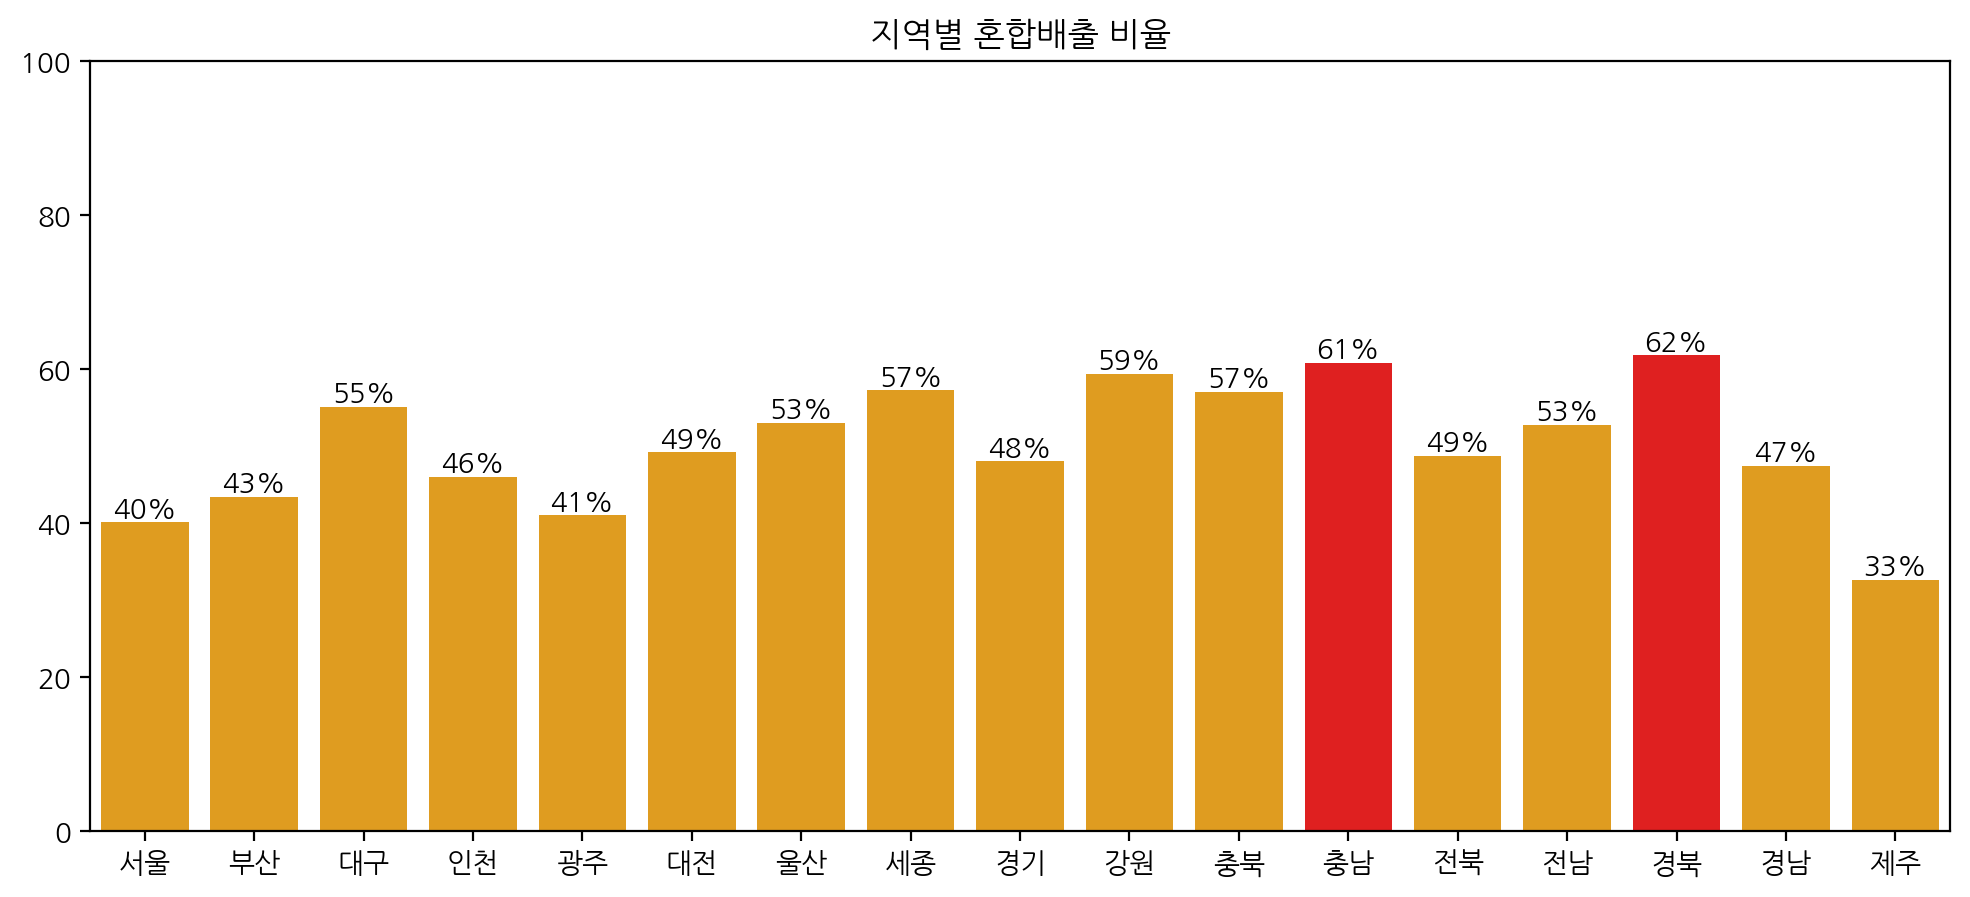

In [3]:
sql = "select (mix_recycle + mix_burn + mix_bury + mix_etc \
            + recycle_recycle + recycle_burn + recycle_bury + recycle_etc \
            + food_recycle + food_burn + food_bury + food_etc) as total \
        from trash"
mycursor.execute(sql)
trash_total = mycursor.fetchall()

sql = "select (mix_recycle + mix_burn + mix_bury + mix_etc) as mix_total from trash"
mycursor.execute(sql)
trash_mix = mycursor.fetchall()

region_list = []

sql = "select region_name from trash"
mycursor.execute(sql)
trash_region = mycursor.fetchall()

for v in trash_region:
    region_list.append(v[0])

mix_rate_list = []

for i, v in enumerate(trash_total):
    mix_rate = (trash_mix[i][0] / trash_total[i][0]) * 100
    mix_rate_list.append(mix_rate)

plt.figure(figsize=(12, 5))
plt.ylim(0, 100)

x_list = region_list
y_list = mix_rate_list

ax = sns.barplot(x=x_list, y=y_list, palette=["r" if y > 60 else "orange" for y in y_list])
ax.bar_label(ax.containers[0], fmt='%.f%%')

plt.title('지역별 혼합배출 비율')
plt.show();

#### 혼합배출 비율이 높다면 반드시 분리수거가 잘 안 된다는, 부정적인 지표일까요?
#### 반대로 혼합배출 비율이 낮다면 분리수거가 잘 된다는 긍정적인 지표로 읽어도 될까요?

- 실제로 플라스틱 등 재활용될 물품의 사용비율이 적어서이기도 할 것입니다.
- 지역별 폐합성수지류(비닐류, 발포수지류, PET병 포함) 폐기물을 확인해보았습니다.

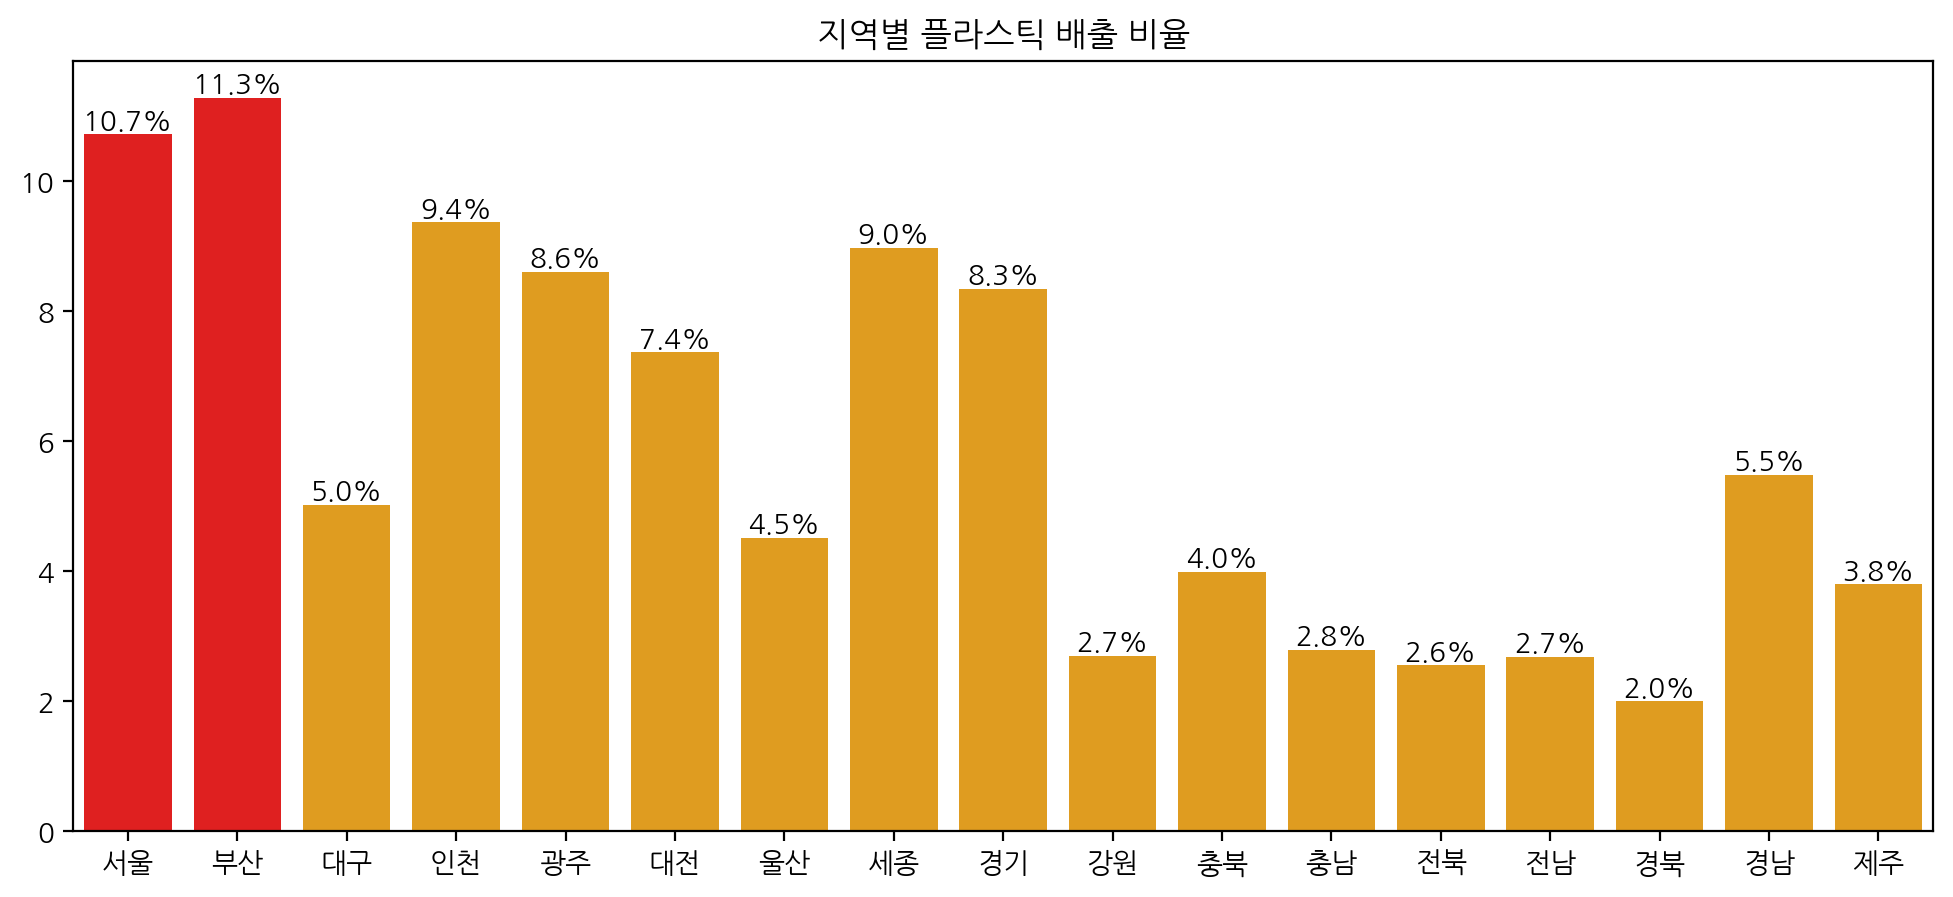

In [4]:
sql = "select plastic from trash"
mycursor.execute(sql)
plastic = mycursor.fetchall()

plastic_rate_list = []

for i, v in enumerate(trash_total):
    plastic_rate = (plastic[i][0] / trash_total[i][0]) * 100
    plastic_rate_list.append(plastic_rate)

plt.figure(figsize=(12, 5))

x_list = region_list
y_list = plastic_rate_list

ax = sns.barplot(x=x_list, y=y_list, palette=["r" if y > 10 else "orange" for y in y_list])
ax.bar_label(ax.containers[0], fmt='%.1f%%')

plt.title('지역별 플라스틱 배출 비율')
plt.show();  # 플라스틱 배출 비율은 서울/부산 등 도시에서 높음

# 실제로 혼합배출 비율이 높은 곳 중 충남, 경북은 플라스틱 배출을 적게 함

#### 종량제로 배출되었는데 재활용 된 폐기물 확인
- 분리배출이 잘 안되고 있다는 뜻 아닐까?

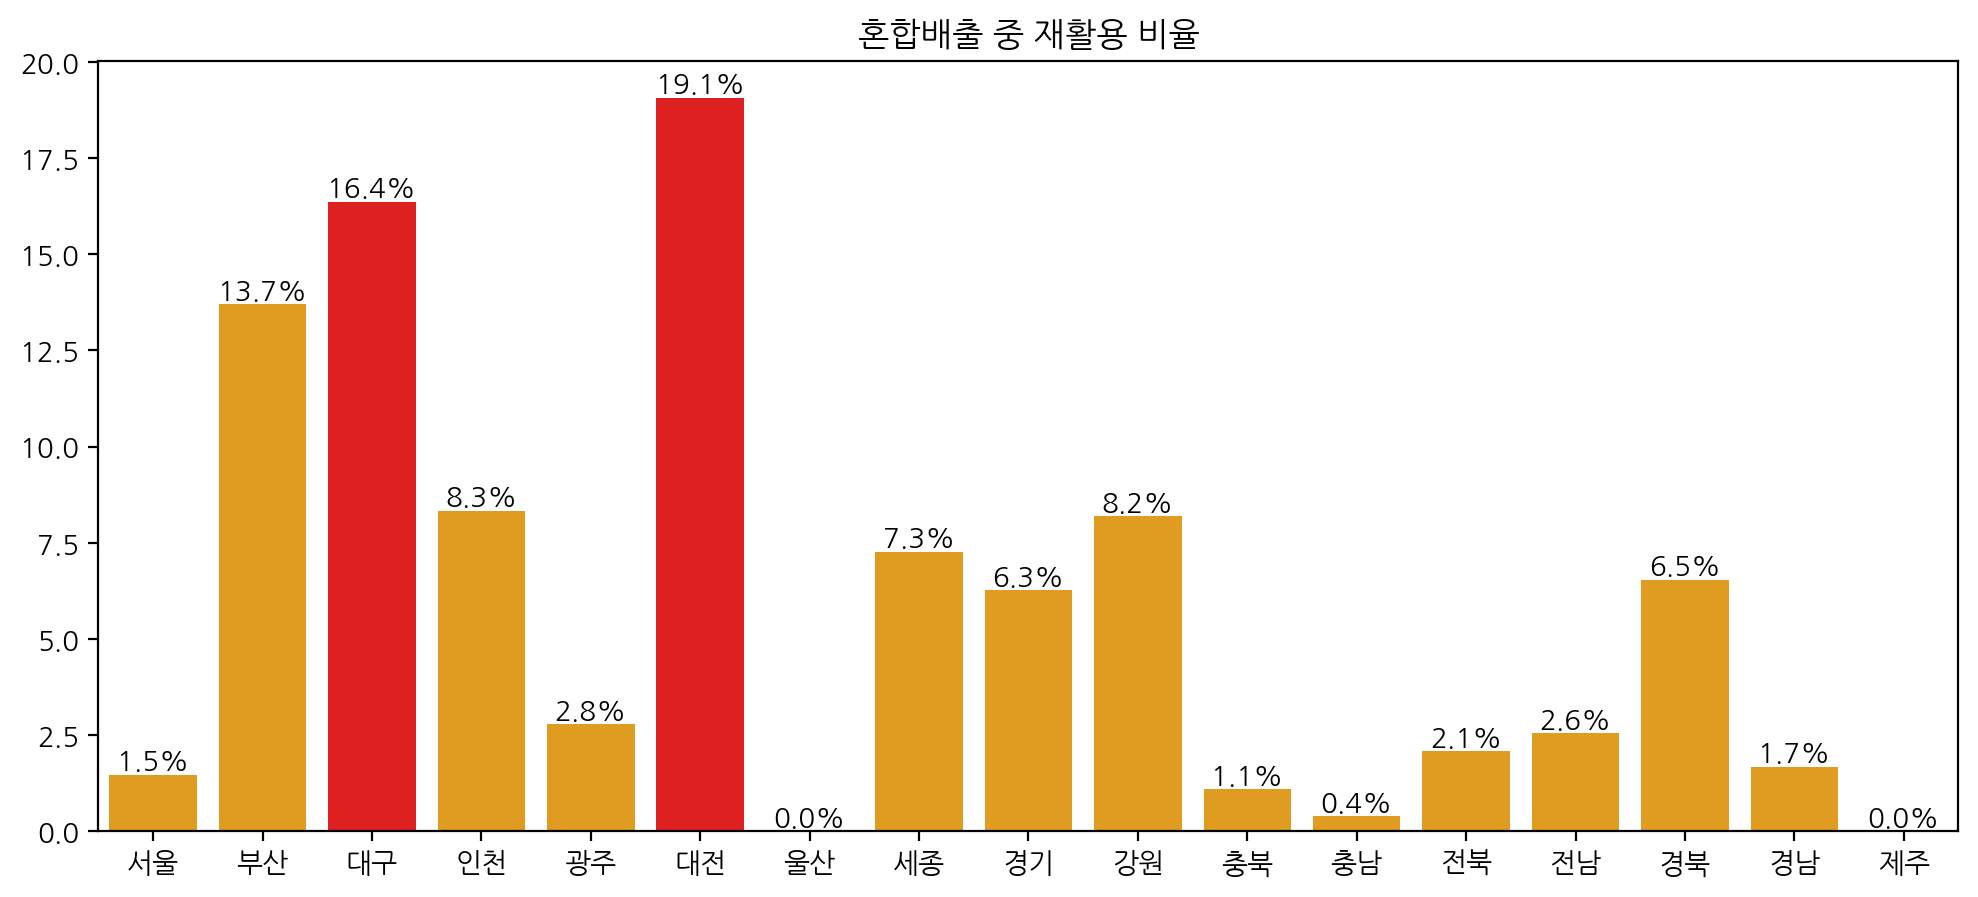

In [5]:
sql = "select mix_recycle from trash"
mycursor.execute(sql)
mix_recycle = mycursor.fetchall()

mix_recycle_rate_list = []

for i, v in enumerate(trash_total):
    mix_recycle_rate = (mix_recycle[i][0] / trash_total[i][0]) * 100
    mix_recycle_rate_list.append(mix_recycle_rate)

plt.figure(figsize=(12, 5))

x_list = region_list
y_list = mix_recycle_rate_list

ax = sns.barplot(x=x_list, y=y_list, palette=["r" if y > 15 else "orange" for y in y_list])
ax.bar_label(ax.containers[0], fmt='%.1f%%')

plt.title('혼합배출 중 재활용 비율')
plt.show();

- 혼합배출된 폐기물에 대한 재분류 작업이 잘되고 있는 의미일 수도 있음

#### 한편, 종이류 폐기율은?
- 택배 이용이 많은 곳일수록, 젊은 층이 많을수록 종이 폐기물이 많을 것으로 예상

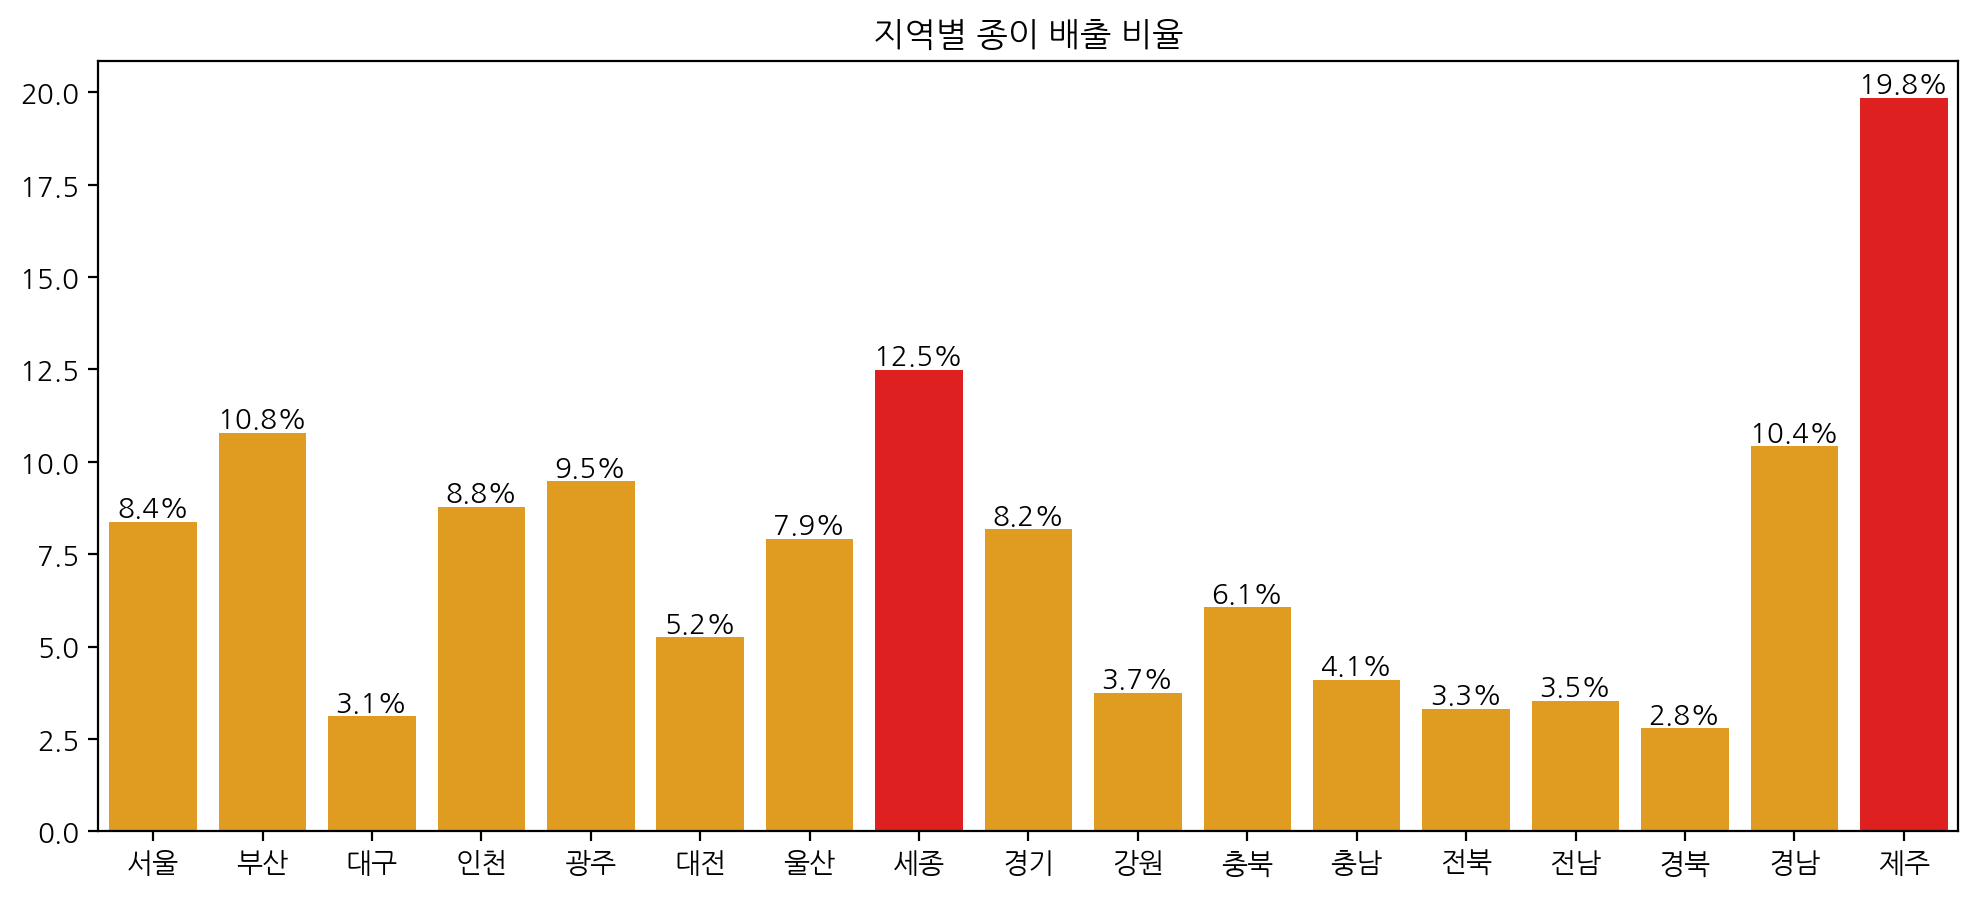

In [6]:
sql = "select paper from trash"
mycursor.execute(sql)
paper = mycursor.fetchall()

paper_rate_list = []

for i, v in enumerate(trash_total):
    paper_rate = (paper[i][0] / trash_total[i][0]) * 100
    paper_rate_list.append(paper_rate)

plt.figure(figsize=(12, 5))

x_list = region_list
y_list = paper_rate_list

ax = sns.barplot(x=x_list, y=y_list, palette=["r" if y > 12 else "orange" for y in y_list])
ax.bar_label(ax.containers[0], fmt='%.1f%%')

plt.title('지역별 종이 배출 비율')
plt.show();

- 제주도에서 종이 배출이 가장 많고, 경북에서 종이 비율이 가장 낮음
- 제주도는 2세대가 많이 사는 곳이기도 한데... 아마 섬이라서 택배 이용이 많은 것이 아닐까? 했습니다.
- 종이 배출을 비율이 아닌 톤수로 비교하고, 지역별 택배 물량(2021년)을 같이 확인해 봅니다.

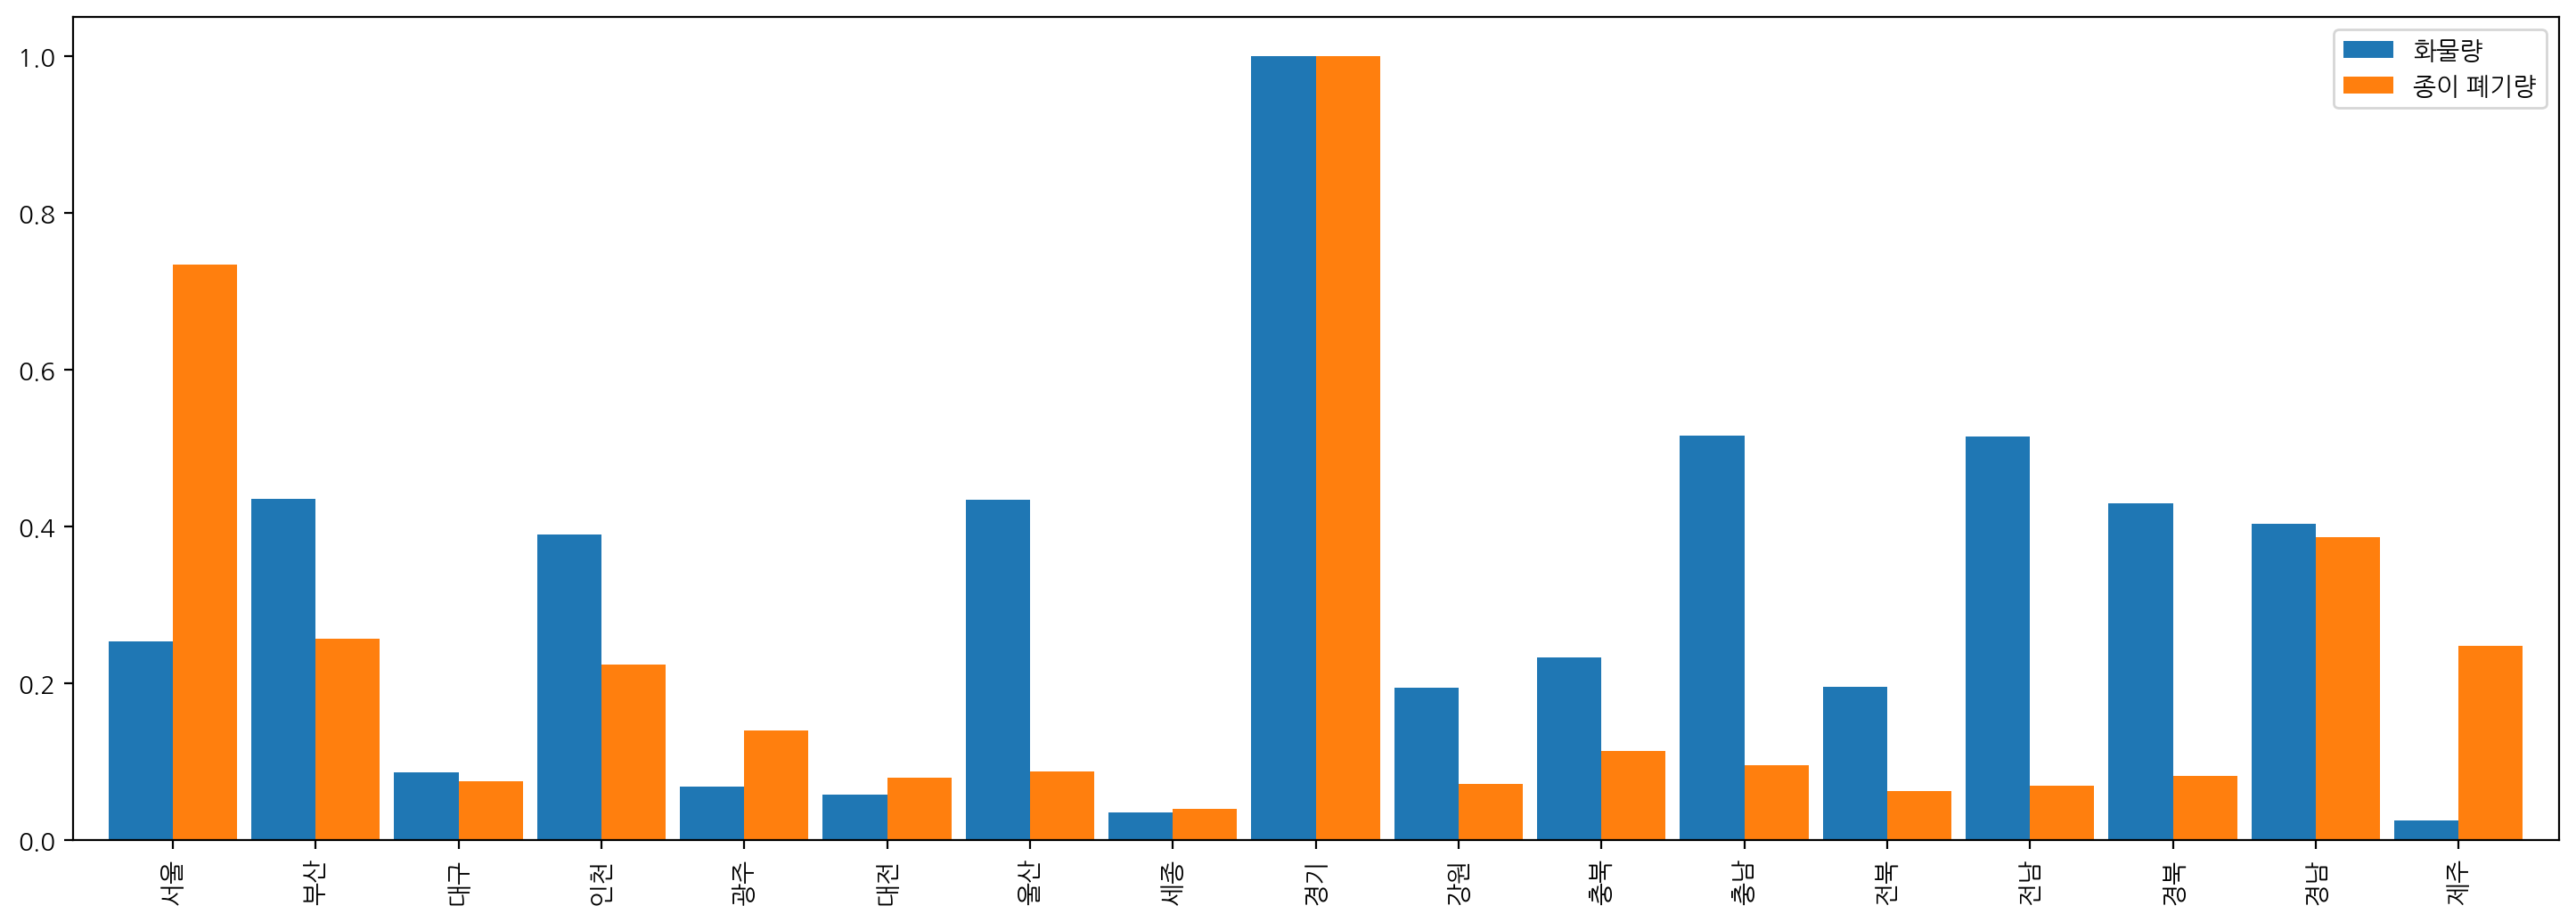

In [7]:
paper_list = []

for p in paper:
    paper_list.append(p[0])

sql = "select parcel_sum from parcel order by region_id"
mycursor.execute(sql)
parcel = mycursor.fetchall()

parcel_list = []

for v in parcel:
    parcel_list.append(v[0])

parcel_df = pd.Series(parcel_list).to_frame()
parcel_df.index = region_list

paper_df = pd.Series(paper_list).to_frame()
paper_df.index = region_list

parcel_norm = parcel_df / parcel_df.max()
paper_norm = paper_df / paper_df.max()

parcel_norm.columns = ['화물량']
paper_norm.columns = ['종이 폐기량']
parcel_norm.merge(paper_norm, left_index=True, right_index=True, how='left').plot.bar(width=0.9)
fig = plt.gcf()
fig.set_size_inches(18,6)
plt.show();  # 제주도 택배량에 비해서도 종이 폐기물이 많습니다
# 택배량과 종이 폐기량이 가장 많은 곳: 경기

#### 배출방식이 다르면 재활용 비율도 다를까?

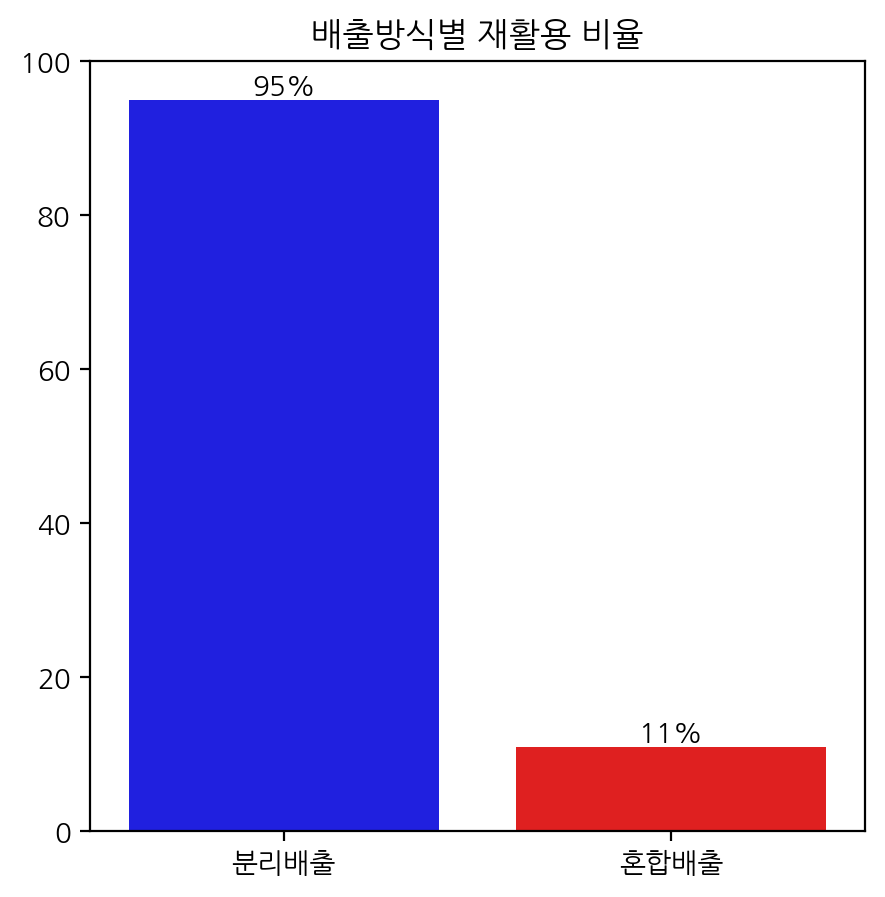

In [8]:
sql = "select sum(recycle_recycle) / sum(recycle_recycle + recycle_burn + recycle_bury + recycle_etc) as recycle_recycle_rate, \
		    sum(mix_recycle) / sum(mix_recycle + mix_burn + mix_bury + mix_etc) as mix_recycle_rate \
        from trash"

mycursor.execute(sql)
recycle_rates = mycursor.fetchone()

recycle_rate_list = []

for rate in recycle_rates:
    recycle_rate_list.append(rate*100)

plt.figure(figsize=(5, 5))
plt.ylim(0, 100)

x_list = ['분리배출', '혼합배출']
y_list = recycle_rate_list

ax = sns.barplot(x=x_list, y=y_list, palette=["b" if y > 90 else "r" for y in y_list])
ax.bar_label(ax.containers[0], fmt='%.f%%')

plt.title('배출방식별 재활용 비율')
plt.show();

- 분리배출 시 재활용 비율이 95퍼센트로 매우 높은데, 혼합배출 시 11 퍼센트에 불과합니다.
    - 단, 이 통계 데이터에서 재활용이란, "재활용처리시설로 반입 처리된 관할구역내의 연간 폐기물량"을 말합니다.
    - 실제 재활용 여부, 특히 '열에너지가 아닌 물질에너지로 재활용이 되는가'는 다루지 않았으므로, 실 재활용 비율은 분리배출된 폐기물이라도 이보다 많이 낮습니다.
    - 참고: 「한국이 분리수거를 잘한다?…재활용률 70%의 '함정'[플라스틱 넷제로]」 (https://www.edaily.co.kr/news/read?newsId=01161126632456840&mediaCodeNo=257)
- 따라서 전체 생활폐기물 배출에서 분리배출 비율을 가능한 한 높일 필요가 있을 것입니다.